# Import library 

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys



# Set arguments

## Arguments for machine

In [3]:
MACHINE = "CPU" #"CPU", "GPU", "GPUs" #str(sys.argv[1])
DEVICES = "-1" #"-1", "0", "0,1" #str(sys.argv[2]) 


## Arguments for dataset

### Simulating metapopulation of SI

In [4]:
SYSTEM_SIZE = 10
NUM_STATE = 2
TIME_LENGTH = 51


### Sampling data

In [5]:
NUM_ENSEMBLE = 100
TRAIN_INI = 0
TRAIN_FIN = 80
VALID_INI = 80
VALID_FIN = 90
TEST_INI = 90
TEST_FIN = 100

## Arguments for model and training

In [8]:
MODEL = "AMFF"
LABEL = 1
TRIAL = 0 #int(sys.argv[13])
BATCHING = 50 #int(sys.argv[3])
LEARNING_RATE = 1e-4 #float(sys.argv[4])
MAX_EPOCH = 100 #int(sys.argv[12])


# Set environment 

## to save model

In [9]:
dir_a = '/pds/pds172/hoyun1009/data/MLMP/MLMP_SI_Tracer/saves/'
dir_b = '/pds/pds172/hoyun1009/data/MLMP/MLMP_SI_Tracer/saves/N{N:d}T{T:d}/'
dir_c = '/pds/pds172/hoyun1009/data/MLMP/MLMP_SI_Tracer/saves/N{N:d}T{T:d}/{M:s}_{L:d}/'
if not os.path.exists(dir_a):
    os.mkdir(dir_a)
if not os.path.exists(dir_b.format(N = SYSTEM_SIZE, T = TIME_LENGTH)):
    os.mkdir(dir_b.format(N = SYSTEM_SIZE, T = TIME_LENGTH))
if not os.path.exists(dir_c.format(N = SYSTEM_SIZE, T = TIME_LENGTH, M = MODEL, L = LABEL)):
    os.mkdir(dir_c.format(N = SYSTEM_SIZE, T = TIME_LENGTH, M = MODEL, L = LABEL))


# Design and compile models

## Modeling and compiling

In [10]:
def ann(model, label):
    
    if model == "AMFF":
        state = tf.keras.Input(shape = (SYSTEM_SIZE, NUM_STATE,), dtype = tf.float32)
        #------------Dense,...------------------
        adjacency = tf.keras.Input(shape = (SYSTEM_SIZE, SYSTEM_SIZE,), dtype = tf.float32)
        #------------Dense,...------------------
        

        x = tf.keras.layers.Attention()([state, state])
        x = tf.einsum('...ij,...jk->...ik', adjacency, x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(SYSTEM_SIZE * NUM_STATE * label, activation = tf.keras.activations.relu)(x)
        x = tf.keras.layers.Dense(SYSTEM_SIZE * NUM_STATE, activation = tf.keras.activations.relu)(x)
        output = tf.keras.layers.Reshape((SYSTEM_SIZE, NUM_STATE,), input_shape=(SYSTEM_SIZE * NUM_STATE,))(x)

    

    model = tf.keras.Model([state, adjacency], output)
    model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), loss = tf.keras.losses.MSE)

    return model


## Load model on the machine

In [11]:
if MACHINE == 'GPUs':
    os.environ["CUDA_VISIBLE_DEVICES"] = DEVICES
    strategy = tf.distribute.MirroredStrategy()
    BATCH_SIZE_REP = BATCHING
    BATCH_SIZE = BATCH_SIZE_REP * strategy.num_replicas_in_sync
    SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 4
    THREAD_DATA = 2 * strategy.num_replicas_in_sync
    with strategy.scope():
        model = ann(MODEL, LABEL)
elif MACHINE == 'CPU' or  MACHINE == 'GPU':
    os.environ["CUDA_VISIBLE_DEVICES"] = DEVICES
    BATCH_SIZE = BATCHING
    SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 4
    THREAD_DATA = 2
    model = ann(MODEL, LABEL)
else:
    print("Select MACHINE : CPU/GPU/GPUs")
    raise SystemExit

    

## Save the structure of the model

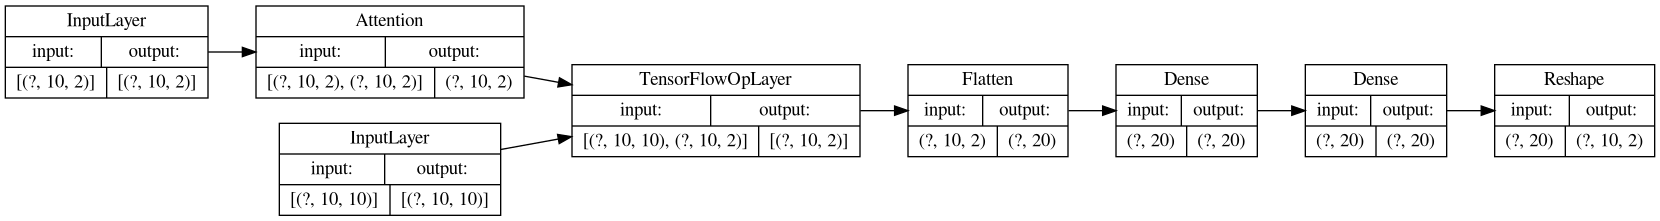

In [12]:

struct = '/pds/pds172/hoyun1009/data/MLMP/MLMP_SI_Tracer/saves/N{N:d}T{T:d}/{M:s}_{L:d}/struct.png'

tf.keras.utils.plot_model(model, to_file = struct.format(N = SYSTEM_SIZE, T = TIME_LENGTH, M = MODEL, L = LABEL), show_shapes = True, show_layer_names = False, rankdir = 'LR')


# Make dataset

## Training dataset

In [14]:
# timeline = np.random.rand(TIME_LENGTH, SYSTEM_SIZE, NUM_STATE)
timeline = np.loadtxt("/pds/pds151/MPML/N1e1M2D3/input.txt", dtype=np.int64)
timeline = timeline.reshape(NUM_ENSEMBLE, TIME_LENGTH, SYSTEM_SIZE, NUM_STATE)

In [15]:
# adjacency = np.random.randint(2, size=(1, SYSTEM_SIZE, SYSTEM_SIZE))
adjacency = np.loadtxt("/pds/pds151/MPML/N1e1M2D3/network_bool.txt", dtype=np.int64)
adjacency = adjacency.reshape(NUM_ENSEMBLE, 1, SYSTEM_SIZE, SYSTEM_SIZE)

In [16]:
number_of_train = (TRAIN_FIN - TRAIN_INI) * (TIME_LENGTH - 1)
input_time_train = tf.data.Dataset.from_tensor_slices(tf.cast(timeline[TRAIN_INI : TRAIN_FIN, 0 : TIME_LENGTH - 1].reshape(number_of_train, SYSTEM_SIZE, NUM_STATE), dtype=tf.float32))
output_time_train = tf.data.Dataset.from_tensor_slices(tf.cast(timeline[TRAIN_INI : TRAIN_FIN, 1 : TIME_LENGTH ].reshape(number_of_train, SYSTEM_SIZE, NUM_STATE), dtype=tf.float32))
adjacency_train = tf.data.Dataset.from_tensor_slices(tf.cast(tf.reshape(tf.tile(adjacency[TRAIN_INI : TRAIN_FIN], tf.constant([1, (TIME_LENGTH - 1), 1, 1], tf.int64)),[number_of_train, SYSTEM_SIZE, SYSTEM_SIZE]), dtype=tf.float32))
dataset_train =  tf.data.Dataset.zip(((input_time_train, adjacency_train), output_time_train)).cache().shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE, drop_remainder = True).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)


In [17]:
number_of_valid = (VALID_FIN - VALID_INI) * (TIME_LENGTH - 1)
input_time_valid = tf.data.Dataset.from_tensor_slices(tf.cast(timeline[VALID_INI : VALID_FIN, 0 : TIME_LENGTH - 1].reshape(number_of_valid, SYSTEM_SIZE, NUM_STATE), dtype=tf.float32))
output_time_valid = tf.data.Dataset.from_tensor_slices(tf.cast(timeline[VALID_INI : VALID_FIN, 1 : TIME_LENGTH].reshape(number_of_valid, SYSTEM_SIZE, NUM_STATE), dtype=tf.float32))
adjacency_valid = tf.data.Dataset.from_tensor_slices(tf.cast(tf.reshape(tf.tile(adjacency[VALID_INI : VALID_FIN], tf.constant([1, (TIME_LENGTH - 1), 1, 1], tf.int64)),[number_of_valid, SYSTEM_SIZE, SYSTEM_SIZE]), dtype=tf.float32))
dataset_valid =  tf.data.Dataset.zip(((input_time_valid, adjacency_valid), output_time_valid)).cache().shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE, drop_remainder = True).prefetch(buffer_size = tf.data.experimental.AUTOTUNE)


# Train the model  

In [18]:
history = model.fit(dataset_train, verbose = 1, epochs = MAX_EPOCH, steps_per_epoch = int(number_of_train / BATCH_SIZE), validation_data = dataset_valid, validation_steps = int(number_of_valid / BATCH_SIZE))
# earlystop_callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = MAX_EPOCH, restore_best_weights = True)]
# earlystop_callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = MAX_EPOCH)]
# history = model.fit(dataset_train, verbose = 0, epochs = int(10 * MAX_EPOCH), steps_per_epoch = int(number_of_train / BATCH_SIZE), validation_data = dataset_valid, validation_steps = int(number_of_valid / BATCH_SIZE), callbacks = earlystop_callbacks)


Epoch 1/100
80/80 [==============================] - 2s 26ms/step - loss: 1447087.0000 - val_loss: 1105044.0000
Epoch 2/100
80/80 [==============================] - 1s 11ms/step - loss: 1067185.8750 - val_loss: 798761.1875
Epoch 3/100
80/80 [==============================] - 1s 6ms/step - loss: 812339.0625 - val_loss: 605758.0625
Epoch 4/100
80/80 [==============================] - 0s 6ms/step - loss: 645339.6250 - val_loss: 491044.4688
Epoch 5/100
80/80 [==============================] - 1s 12ms/step - loss: 540458.6875 - val_loss: 430837.5625
Epoch 6/100
80/80 [==============================] - 0s 5ms/step - loss: 476605.3125 - val_loss: 396926.5625
Epoch 7/100
80/80 [==============================] - 1s 8ms/step - loss: 439013.2500 - val_loss: 377699.5000
Epoch 8/100
80/80 [==============================] - 1s 10ms/step - loss: 415607.5312 - val_loss: 366519.5000
Epoch 9/100
80/80 [==============================] - 0s 6ms/step - loss: 400143.5312 - val_loss: 358338.6562
Epoch 10/100

## To record history

In [19]:
history_pdf = '/pds/pds172/hoyun1009/data/MLMP/MLMP_SI_Tracer/saves/N{N:d}T{T:d}/{M:s}_{L:d}/history_{trial:d}.pdf'
history_dat = '/pds/pds172/hoyun1009/data/MLMP/MLMP_SI_Tracer/saves/N{N:d}T{T:d}/{M:s}_{L:d}/history_{trial:d}.dat'


In [20]:
def plot_history(hist, filename):
    plt.clf()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist[:,0], label='Train')
    plt.plot(hist[:,1], label = 'Validation')
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)



In [21]:
hist = np.column_stack((history.history['loss'], history.history['val_loss']))



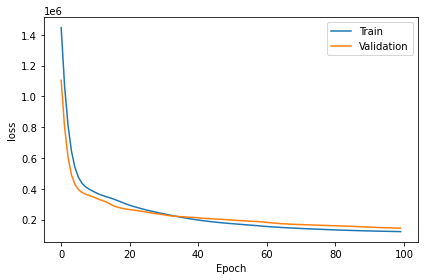

In [22]:
plot_history(hist, history_pdf.format(N = SYSTEM_SIZE, T = TIME_LENGTH, M = MODEL, L = LABEL, trial = TRIAL))
np.savetxt(history_dat.format(N = SYSTEM_SIZE, T = TIME_LENGTH, M = MODEL, L = LABEL, trial = TRIAL), hist, fmt = "%e")




In [23]:

save_dir = '/pds/pds172/hoyun1009/data/MLMP/MLMP_SI_Tracer/saves/N{N:d}T{T:d}/{M:s}_{L:d}/save_{trial:d}/'
if not os.path.exists(save_dir.format(N = SYSTEM_SIZE, T = TIME_LENGTH, M = MODEL, L = LABEL, trial = TRIAL)):
    os.mkdir(save_dir.format(N = SYSTEM_SIZE, T = TIME_LENGTH, M = MODEL, L = LABEL, trial = TRIAL))
save = '/pds/pds172/hoyun1009/data/MLMP/MLMP_SI_Tracer/saves/N{N:d}T{T:d}/{M:s}_{L:d}/save_{trial:d}/save.ckpt'
model.save_weights(save.format(N = SYSTEM_SIZE, T = TIME_LENGTH, M = MODEL, L = LABEL, trial = TRIAL))


# Testing model

In [24]:

output = np.zeros((TEST_FIN - TEST_INI, TIME_LENGTH, SYSTEM_SIZE, NUM_STATE), dtype=np.float32)

input_time_test = tf.cast(timeline[TEST_INI : TEST_FIN, 0 : 1].reshape(TEST_FIN - TEST_INI, SYSTEM_SIZE, NUM_STATE), dtype=tf.float32)
adjacency_test = tf.data.Dataset.from_tensor_slices(tf.cast(adjacency[TEST_INI : TEST_FIN].reshape(TEST_FIN - TEST_INI, SYSTEM_SIZE, SYSTEM_SIZE), dtype=tf.float32))
output[:,0] = input_time_test


for i in range(1, TIME_LENGTH - 1):
    image_test = tf.data.Dataset.from_tensor_slices(input_time_test)
    label_test = tf.data.Dataset.from_tensor_slices(tf.cast(timeline[TEST_INI : TEST_FIN, i : i + 1].reshape(TEST_FIN - TEST_INI, SYSTEM_SIZE, NUM_STATE), dtype=tf.float32))
    dataset_test =  tf.data.Dataset.zip(((image_test, adjacency_test), label_test)).batch(TEST_FIN - TEST_INI, drop_remainder = True)
    output[:,i] = model.predict(dataset_test)
    input_time_test = output[:,i]



In [25]:
output_dat = '/pds/pds172/hoyun1009/data/MLMP/MLMP_SI_Tracer/saves/N{N:d}T{T:d}/{M:s}_{L:d}/output_{trial:d}.dat'
np.savetxt(output_dat.format(N = SYSTEM_SIZE, T = TIME_LENGTH, M = MODEL, L = LABEL, trial = TRIAL), output.reshape(TEST_FIN - TEST_INI, TIME_LENGTH * SYSTEM_SIZE * NUM_STATE), fmt = "%e")



In [26]:
def plot_output(label, output, filename):
    plt.clf()
    plt.xlabel('Time')
    plt.ylabel('Infectious')
    for sample in range(0,2):
        plt.plot(label[sample,:,1], label = str(sample), color = 'C'+str(sample), linestyle = 'solid' )
        plt.plot(output[sample,:,1], color = 'C'+str(sample), linestyle = 'dotted')
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)




In [27]:
output_pdf = '/pds/pds172/hoyun1009/data/MLMP/MLMP_SI_Tracer/saves/N{N:d}T{T:d}/{M:s}_{L:d}/output_{trial:d}.pdf'

In [28]:
label_sum = tf.reduce_sum(tf.cast(timeline[TEST_INI : TEST_FIN].reshape(TEST_FIN - TEST_INI, TIME_LENGTH, SYSTEM_SIZE, NUM_STATE), dtype=tf.float32), 2)
output_sum = tf.reduce_sum(output, 2)

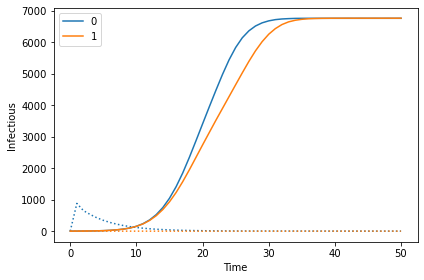

In [29]:
plot_output(label_sum, output_sum, output_pdf.format(N = SYSTEM_SIZE, T = TIME_LENGTH, M = MODEL, L = LABEL, trial = TRIAL))